In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from software.preprocessing.video_data.DLC.Reconstruction import dlt_reconstruct
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error
import os

In [2]:
#os.chdir()
rm10_prediction_csvs = ['/Brett Stuff/March Labels/ground_truths_C1_RM10DLC_resnet_101_LabLabelOct27shuffle1_700000.csv', '/Brett Stuff/March Labels/ground_truths_cam2_RM10DLC_resnet_101_LabLabelOct27shuffle1_700000.csv', '/Brett Stuff/March Labels/ground_truths_cam3_RM10DLC_resnet_101_LabLabelOct27shuffle1_700000.csv']
rm10_filtered_prediction_csvs = ['/Brett Stuff/March Labels/ground_truths_C1_RM10DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv', '/Brett Stuff/March Labels/ground_truths_cam2_RM10DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv', '/Brett Stuff/March Labels/ground_truths_cam3_RM10DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv']
rm11_prediction_csvs = ['/Brett Stuff/March Labels/ground_truths_cam1_RM11DLC_resnet_101_LabLabelOct27shuffle1_700000.csv', '/Brett Stuff/March Labels/ground_truths_cam2_RM11DLC_resnet_101_LabLabelOct27shuffle1_700000.csv', '/Brett Stuff/March Labels/ground_truths_cam3_RM11DLC_resnet_101_LabLabelOct27shuffle1_700000.csv']
rm11_filtered_prediction_csvs = ['/Brett Stuff/March Labels/ground_truths_cam1_RM11DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv', '/Brett Stuff/March Labels/ground_truths_cam2_RM11DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv', '/Brett Stuff/March Labels/ground_truths_cam3_RM11DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv']
rm13_prediction_csvs = ['/Brett Stuff/March Labels/ground_truths_cam1_RM13DLC_resnet_101_LabLabelOct27shuffle1_700000.csv', '/Brett Stuff/March Labels/ground_truths_cam2_RM13DLC_resnet_101_LabLabelOct27shuffle1_700000.csv', '/Brett Stuff/March Labels/ground_truths_cam3_RM13DLC_resnet_101_LabLabelOct27shuffle1_700000.csv']
rm13_filtered_prediction_csvs = ['/Brett Stuff/March Labels/ground_truths_cam1_RM13DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv', '/Brett Stuff/March Labels/ground_truths_cam2_RM13DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv', '/Brett Stuff/March Labels/ground_truths_cam3_RM13DLC_resnet_101_LabLabelOct27shuffle1_700000_filtered.csv']
rm10_label_csvs = ['/Brett Stuff/March Labels/CollectedData_Lab_cam1_RM10.csv', '/Brett Stuff/March Labels/CollectedData_Lab_cam2_RM10.csv', '/Brett Stuff/March Labels/CollectedData_Lab_cam3_RM10.csv']
rm11_label_csvs = ['/Brett Stuff/March Labels/CollectedData_Lab_cam1_RM11.csv', '/Brett Stuff/March Labels/CollectedData_Lab_cam2_RM11.csv', '/Brett Stuff/March Labels/CollectedData_Lab_cam3_RM11.csv']
rm13_label_csvs = ['/Brett Stuff/March Labels/CollectedData_Lab_cam1_RM13.csv', '/Brett Stuff/March Labels/CollectedData_Lab_cam2_RM13.csv', '/Brett Stuff/March Labels/CollectedData_Lab_cam3_RM13.csv']

In [9]:
desktop_path = '/Users/bassp/OneDrive/Desktop/'


def add_path_to_csv(csv_list,user_path):
    for iz, paths in enumerate(csv_list):
        csv_list[iz] = user_path + paths 
    return csv_list

rm10_prediction_csvs = add_path_to_csv(rm10_prediction_csvs,desktop_path)
rm11_prediction_csvs = add_path_to_csv(rm11_prediction_csvs,desktop_path)
rm13_prediction_csvs = add_path_to_csv(rm13_prediction_csvs,desktop_path)
rm10_label_csvs = add_path_to_csv(rm10_label_csvs,desktop_path)
rm11_label_csvs = add_path_to_csv(rm11_label_csvs,desktop_path)
rm13_label_csvs = add_path_to_csv(rm13_label_csvs,desktop_path)
rm11_filtered_prediction_csvs = add_path_to_csv(rm11_filtered_prediction_csvs,desktop_path)
rm10_filtered_prediction_csvs = add_path_to_csv(rm10_filtered_prediction_csvs,desktop_path)
rm13_filtered_prediction_csvs = add_path_to_csv(rm13_filtered_prediction_csvs,desktop_path)

In [3]:
def process_csv(prediction_csvs, label_csvs):
    data_dict = {}
    cam1_csv = np.loadtxt(label_csvs[0], dtype=str, delimiter=",")
    names = cam1_csv[1,1::2].copy()

    cam1_dlc_data = np.loadtxt(prediction_csvs[0], skiprows=3, delimiter=",")[:, 1:]
    cam2_dlc_data = np.loadtxt(prediction_csvs[1], skiprows=3, delimiter=",")[:, 1:]
    cam3_dlc_data = np.loadtxt(prediction_csvs[2], skiprows=3, delimiter=",")[:, 1:]

    cam1_csv_data = np.genfromtxt(label_csvs[0], delimiter=",", skip_header=3, usecols=range(1, len(names)*2 + 1))
    cam2_csv_data = np.genfromtxt(label_csvs[1], delimiter=",", skip_header=3, usecols=range(1, len(names)*2 + 1))
    cam3_csv_data = np.genfromtxt(label_csvs[2], delimiter=",", skip_header=3, usecols=range(1, len(names)*2 + 1))

    discarded = set()
    shortest_len = min(cam1_dlc_data.shape[0], cam2_dlc_data.shape[0], cam3_dlc_data.shape[0])
    for i in range(len(names)):
        labelled_idx = i * 2
        predicted_idx = i * 3
        entry_dict = {}

        cam1_labelled_x = cam1_csv_data[:shortest_len, labelled_idx].copy()
        cam1_predicted_x = cam1_dlc_data[:shortest_len, predicted_idx].copy()
        cam1_labelled_y = cam1_csv_data[:shortest_len, labelled_idx + 1].copy()
        cam1_predicted_y = cam1_dlc_data[:shortest_len, predicted_idx + 1].copy()
        cam1_predicted_prob = cam1_dlc_data[:shortest_len, predicted_idx + 2].copy()
        
        cam2_labelled_x = cam2_csv_data[:shortest_len, labelled_idx].copy()
        cam2_predicted_x = cam2_dlc_data[:shortest_len, predicted_idx].copy()
        cam2_labelled_y = cam2_csv_data[:shortest_len, labelled_idx + 1].copy()
        cam2_predicted_y = cam2_dlc_data[:shortest_len, predicted_idx + 1].copy()
        cam2_predicted_prob = cam2_dlc_data[:shortest_len, predicted_idx + 2].copy()

        cam3_labelled_x = cam3_csv_data[:shortest_len, labelled_idx].copy()
        cam3_predicted_x = cam3_dlc_data[:shortest_len, predicted_idx].copy()
        cam3_labelled_y = cam3_csv_data[:shortest_len, labelled_idx + 1].copy()
        cam3_predicted_y = cam3_dlc_data[:shortest_len, predicted_idx + 1].copy()
        cam3_predicted_prob = cam3_dlc_data[:shortest_len, predicted_idx + 2].copy()


        mask = np.isnan(cam1_labelled_x) | np.isnan(cam1_labelled_y) | np.isnan(cam2_labelled_x) | np.isnan(cam2_labelled_y) | np.isnan(cam3_labelled_x) | np.isnan(cam3_labelled_y)
        if np.sum(~mask) < 10:
            print("Not enough entries for {}, discarding".format(names[i]))
            discarded.add(names[i])
            continue
        cam1_labelled_x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam1_labelled_x[~mask])
        cam1_labelled_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam1_labelled_y[~mask])
        cam2_labelled_x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam2_labelled_x[~mask])
        cam2_labelled_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam2_labelled_y[~mask])
        cam3_labelled_x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam3_labelled_x[~mask])
        cam3_labelled_y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), cam3_labelled_y[~mask])
        
        entry_dict["Camera 1"] = {}
        entry_dict["Camera 1"]["labelled_x"] = cam1_labelled_x
        entry_dict["Camera 1"]["predicted_x"] = cam1_predicted_x
        entry_dict["Camera 1"]["labelled_y"] = cam1_labelled_y
        entry_dict["Camera 1"]["predicted_y"] = cam1_predicted_y
        entry_dict["Camera 1"]["predicted_prob"] = cam1_predicted_prob
        entry_dict["Camera 1"]["max_x"] = max(np.max(entry_dict["Camera 1"]["labelled_x"]), np.max(entry_dict["Camera 1"]["predicted_x"]))
        entry_dict["Camera 1"]["max_y"] = max(np.max(entry_dict["Camera 1"]["labelled_y"]), np.max(entry_dict["Camera 1"]["predicted_y"]))
        entry_dict["Camera 1"]["min_x"] = min(np.min(entry_dict["Camera 1"]["labelled_x"]), np.min(entry_dict["Camera 1"]["predicted_x"]))
        entry_dict["Camera 1"]["min_y"] = min(np.min(entry_dict["Camera 1"]["labelled_y"]), np.min(entry_dict["Camera 1"]["predicted_y"]))

        entry_dict["Camera 2"] = {}
        entry_dict["Camera 2"]["labelled_x"] = cam2_labelled_x
        entry_dict["Camera 2"]["predicted_x"] = cam2_predicted_x
        entry_dict["Camera 2"]["labelled_y"] = cam2_labelled_y
        entry_dict["Camera 2"]["predicted_y"] = cam2_predicted_y
        entry_dict["Camera 2"]["predicted_prob"] = cam2_predicted_prob
        entry_dict["Camera 2"]["max_x"] = max(np.max(entry_dict["Camera 2"]["labelled_x"]), np.max(entry_dict["Camera 2"]["predicted_x"]))
        entry_dict["Camera 2"]["max_y"] = max(np.max(entry_dict["Camera 2"]["labelled_y"]), np.max(entry_dict["Camera 2"]["predicted_y"]))
        entry_dict["Camera 2"]["min_x"] = min(np.min(entry_dict["Camera 2"]["labelled_x"]), np.min(entry_dict["Camera 2"]["predicted_x"]))
        entry_dict["Camera 2"]["min_y"] = min(np.min(entry_dict["Camera 2"]["labelled_y"]), np.min(entry_dict["Camera 2"]["predicted_y"]))

        entry_dict["Camera 3"] = {}
        entry_dict["Camera 3"]["labelled_x"] = cam3_labelled_x
        entry_dict["Camera 3"]["predicted_x"] = cam3_predicted_x
        entry_dict["Camera 3"]["labelled_y"] = cam3_labelled_y
        entry_dict["Camera 3"]["predicted_y"] = cam3_predicted_y
        entry_dict["Camera 3"]["predicted_prob"] = cam3_predicted_prob
        entry_dict["Camera 3"]["max_x"] = max(np.max(entry_dict["Camera 3"]["labelled_x"]), np.max(entry_dict["Camera 3"]["predicted_x"]))
        entry_dict["Camera 3"]["max_y"] = max(np.max(entry_dict["Camera 3"]["labelled_y"]), np.max(entry_dict["Camera 3"]["predicted_y"]))
        entry_dict["Camera 3"]["min_x"] = min(np.min(entry_dict["Camera 3"]["labelled_x"]), np.min(entry_dict["Camera 3"]["predicted_x"]))
        entry_dict["Camera 3"]["min_y"] = min(np.min(entry_dict["Camera 3"]["labelled_y"]), np.min(entry_dict["Camera 3"]["predicted_y"]))
        data_dict[names[i]] = entry_dict
    filtered_names = [name for name in names if name not in discarded]
    data_dict["filtered_names"] = filtered_names
    thres = 0.05
    for name in filtered_names:
        for cam in ["Camera 1", "Camera 2", "Camera 3"]:
            mask = data_dict[name][cam]["predicted_prob"] < thres
            data_dict[name][cam]["interp_predicted_prob"] = data_dict[name][cam]["predicted_prob"].copy()
            data_dict[name][cam]["interp_predicted_prob"][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_dict[name][cam]["predicted_prob"][~mask])
            data_dict[name][cam]["interp_predicted_x"] = data_dict[name][cam]["predicted_x"].copy()
            data_dict[name][cam]["interp_predicted_x"][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_dict[name][cam]["predicted_x"][~mask])
            data_dict[name][cam]["interp_predicted_y"] = data_dict[name][cam]["predicted_y"].copy()
            data_dict[name][cam]["interp_predicted_y"][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), data_dict[name][cam]["predicted_y"][~mask])
    return data_dict

In [4]:
def get_reconstructions(data_dict, dlt_coefs_file):
    dlt_coefs = np.loadtxt(dlt_coefs_file, delimiter=",")
    reconstructions = {}
    for name in data_dict["filtered_names"]:
        # read in data from DLC
        frames = data_dict[name]["Camera 1"]["labelled_x"].shape[0]
        cam_data = np.empty([frames, 6], dtype=float)
        weights = np.empty([frames, 6], dtype=float)

        cam_data[:, 0] = data_dict[name]["Camera 1"]["labelled_x"]
        cam_data[:, 1] = data_dict[name]["Camera 1"]["labelled_y"]
        cam_data[:, 2] = data_dict[name]["Camera 2"]["labelled_x"]
        cam_data[:, 3] = data_dict[name]["Camera 2"]["labelled_y"]
        cam_data[:, 4] = data_dict[name]["Camera 3"]["labelled_x"]
        cam_data[:, 5] = data_dict[name]["Camera 3"]["labelled_y"]

        xyz_labelled = dlt_reconstruct(dlt_coefs, cam_data)

        cam_data[:, 0] = data_dict[name]["Camera 1"]["predicted_x"]
        cam_data[:, 1] = data_dict[name]["Camera 1"]["predicted_y"]
        cam_data[:, 2] = data_dict[name]["Camera 2"]["predicted_x"]
        cam_data[:, 3] = data_dict[name]["Camera 2"]["predicted_y"]
        cam_data[:, 4] = data_dict[name]["Camera 3"]["predicted_x"]
        cam_data[:, 5] = data_dict[name]["Camera 3"]["predicted_y"]
        
        weights[:, 0] = data_dict[name]["Camera 1"]["predicted_prob"]
        weights[:, 1] = data_dict[name]["Camera 1"]["predicted_prob"]
        weights[:, 2] = data_dict[name]["Camera 2"]["predicted_prob"]
        weights[:, 3] = data_dict[name]["Camera 2"]["predicted_prob"]
        weights[:, 4] = data_dict[name]["Camera 3"]["predicted_prob"]
        weights[:, 5] = data_dict[name]["Camera 3"]["predicted_prob"]

        xyz_predicted_weighted = dlt_reconstruct(dlt_coefs, cam_data, weights)
        xyz_predicted_unweighted = dlt_reconstruct(dlt_coefs, cam_data)

        cam_data[:, 0] = data_dict[name]["Camera 1"]["interp_predicted_x"]
        cam_data[:, 1] = data_dict[name]["Camera 1"]["interp_predicted_y"]
        cam_data[:, 2] = data_dict[name]["Camera 2"]["interp_predicted_x"]
        cam_data[:, 3] = data_dict[name]["Camera 2"]["interp_predicted_y"]
        cam_data[:, 4] = data_dict[name]["Camera 3"]["interp_predicted_x"]
        cam_data[:, 5] = data_dict[name]["Camera 3"]["interp_predicted_y"]
        
        weights[:, 0] = data_dict[name]["Camera 1"]["interp_predicted_prob"]
        weights[:, 1] = data_dict[name]["Camera 1"]["interp_predicted_prob"]
        weights[:, 2] = data_dict[name]["Camera 2"]["interp_predicted_prob"]
        weights[:, 3] = data_dict[name]["Camera 2"]["interp_predicted_prob"]
        weights[:, 4] = data_dict[name]["Camera 3"]["interp_predicted_prob"]
        weights[:, 5] = data_dict[name]["Camera 3"]["interp_predicted_prob"]

        xyz_interp_predicted_weighted = dlt_reconstruct(dlt_coefs, cam_data, weights)
        xyz_interp_predicted_unweighted = dlt_reconstruct(dlt_coefs, cam_data)

        reconstructions[name] = {}
        reconstructions[name]["xyz_labelled"] = xyz_labelled
        reconstructions[name]["xyz_predicted_weighted"] = xyz_predicted_weighted
        reconstructions[name]["xyz_predicted_unweighted"] = xyz_predicted_unweighted
        reconstructions[name]["xyz_interp_predicted_weighted"] = xyz_interp_predicted_weighted
        reconstructions[name]["xyz_interp_predicted_unweighted"] = xyz_interp_predicted_unweighted
        reconstructions[name]["xyz_predicted_prob"] = np.mean(np.array([data_dict[name]["Camera 1"]["predicted_prob"], data_dict[name]["Camera 2"]["predicted_prob"], data_dict[name]["Camera 3"]["predicted_prob"]]), axis=0)
        reconstructions[name]["xyz_interp_predicted_prob"] = np.mean(np.array([data_dict[name]["Camera 1"]["interp_predicted_prob"], data_dict[name]["Camera 2"]["interp_predicted_prob"], data_dict[name]["Camera 3"]["interp_predicted_prob"]]), axis=0)
    return reconstructions

In [10]:
import os
dlt_coefs_file = 'Brett Stuff/DeepLabCutCSVs/test_dlt.csv'



rm10_data_dict = process_csv(rm10_prediction_csvs, rm10_label_csvs)
rm10_filtered_data_dict = process_csv(rm10_filtered_prediction_csvs, rm10_label_csvs)
rm11_data_dict = process_csv(rm11_prediction_csvs, rm11_label_csvs)
rm11_filtered_data_dict = process_csv(rm11_filtered_prediction_csvs, rm11_label_csvs)
rm13_data_dict = process_csv(rm13_prediction_csvs, rm13_label_csvs)
rm13_filtered_data_dict = process_csv(rm13_filtered_prediction_csvs, rm13_label_csvs)
rm10_reconstructions = get_reconstructions(rm10_data_dict, dlt_coefs_file)
rm10_filtered_reconstructions = get_reconstructions(rm10_filtered_data_dict, dlt_coefs_file)
rm11_reconstructions = get_reconstructions(rm11_data_dict, dlt_coefs_file)
rm11_filtered_reconstructions = get_reconstructions(rm11_filtered_data_dict, dlt_coefs_file)
rm13_reconstructions = get_reconstructions(rm13_data_dict, dlt_coefs_file)
rm13_filtered_reconstructions = get_reconstructions(rm13_filtered_data_dict, dlt_coefs_file)

Not enough entries for Shoulder 1, discarding
Not enough entries for Forearm 1, discarding
Not enough entries for Wrist 1, discarding
Not enough entries for Palm 1, discarding
Not enough entries for Index Base 1, discarding
Not enough entries for Index Tip 1, discarding
Not enough entries for Middle Base 1, discarding
Not enough entries for Middle Tip 1, discarding
Not enough entries for Third Base 1, discarding
Not enough entries for Third tip 1, discarding
Not enough entries for Fourth Base 1, discarding
Not enough entries for Fourth tip 1, discarding
Not enough entries for Shoulder 1, discarding
Not enough entries for Forearm 1, discarding
Not enough entries for Wrist 1, discarding
Not enough entries for Palm 1, discarding
Not enough entries for Index Base 1, discarding
Not enough entries for Index Tip 1, discarding
Not enough entries for Middle Base 1, discarding
Not enough entries for Middle Tip 1, discarding
Not enough entries for Third Base 1, discarding
Not enough entries for T

In [11]:
reconstructions = [rm10_reconstructions, rm10_filtered_reconstructions, rm11_reconstructions, rm11_filtered_reconstructions, rm13_reconstructions, rm13_filtered_reconstructions]
errors = []
for reconstruction in reconstructions:
    errors.append(np.array([mean_squared_error(reconstruction[name]["xyz_labelled"], reconstruction[name]["xyz_predicted_weighted"], squared=False) for name in reconstruction.keys()]))

In [12]:
errors

[array([0.00096144, 0.00107499, 0.00518206, 0.0213167 , 0.02157859,
        0.03186075, 0.02895089, 0.04143931, 0.03895343, 0.03531126,
        0.03407143, 0.03307112, 0.03358856, 0.0281653 , 0.03200207]),
 array([0.00094029, 0.00107344, 0.00465873, 0.02139258, 0.02102012,
        0.03153333, 0.02980257, 0.0416228 , 0.03869293, 0.03551437,
        0.03421277, 0.03245278, 0.03345753, 0.02838483, 0.03211113]),
 array([0.00638667, 0.00655445, 0.00176659, 0.00897744, 0.00317473,
        0.00254189, 0.01802869, 0.0110773 , 0.00986376, 0.01235501,
        0.01751035]),
 array([0.00637537, 0.00654537, 0.00176333, 0.00902509, 0.00334422,
        0.00272393, 0.01780831, 0.01105982, 0.00966835, 0.01228855,
        0.01734583]),
 array([0.00099716, 0.00093879, 0.00253785, 0.0161437 , 0.00658326,
        0.01765128, 0.01374207]),
 array([0.00097686, 0.00092787, 0.00269363, 0.01559202, 0.00669451,
        0.01731774, 0.01391658])]

Text(0.5, 1.0, 'RMSE Distibution across Body Parts')

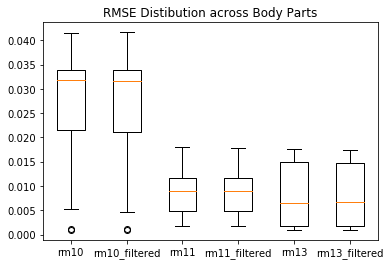

In [13]:
rat_labels = ["rm10", "rm10_filtered", "rm11", "rm11_filtered", "rm13", "rm13_filtered"]
plt.boxplot(errors, labels=rat_labels)
plt.title("RMSE Distibution across Body Parts")

In [ ]:
all_reconstructions = {k: v for k, v in list(zip(rat_labels, reconstructions))}

In [ ]:
import pickle
pickle.dump(all_reconstructions, open("all_reconstructions.pickle", "wb"))